# Pneumonia_Chest_X-Ray

CNN image detection of pneumonia from chest xrays.  
Project By: [Uzair Bin Asim](https://github.com/Uzair05)

In [1]:
import os 
import zipfile

## Download dataset

In [ ]:
#!pip install --upgrade kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [ ]:
try:
    if not os.path.isdir("./data"):
        os.mkdir("./data")
except Exception as err:
    print(f"Error in creating data/:\t{err}")

if os.path.isfile("./chest-xray-pneumonia.zip"):
    localzip = "./chest-xray-pneumonia.zip"
    with zipfile.ZipFile(localzip, 'r') as zip_ref:
        zip_ref.extractall('data/')

In [ ]:
## Clean the dataspace
# !rm -rf data/chest_xray/__MACOSX
# !cd data/ && find -type f | grep -E "\.DS_Store" | xargs -I{} rm {}

## Handle Data
Create the train, test, and validation datasets.

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
main_path = "data/chest_xray/chest_xray"

test_dir, train_dir = os.path.join(main_path, "test"), os.path.join(main_path, "train")
validation_dir = os.path.join(main_path, "val") 

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0, 
    rotation_range=10, 
    width_shift_range=0.3, 
    height_shift_range=0.3, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)
val_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150,150), 
    class_mode='binary', 
    batch_size=20
)
test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(150,150), 
    class_mode='binary', 
    batch_size=20
)
val_generator = val_datagen.flow_from_directory(
    validation_dir, 
    target_size=(150,150), 
    class_mode='binary', 
    batch_size=20
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Create Model

In [8]:
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.optimizers import RMSprop

In [9]:
pretrained_model = EfficientNetB3(
    include_top=False, 
    weights='imagenet', 
    input_shape=(150,150,3)
)

for layer in pretrained_model.layers:
  layer.trainable = False

pretrained_model.trainable = False

pretrained_model.summary()

last_layer = pretrained_model.get_layer('top_activation')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

Model: "efficientnetb3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 150, 150, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 150, 150, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [11]:
from tensorflow.keras.layers import Flatten, Dense, Dropout

In [12]:
x = Flatten()(last_output)
#x = Dense(32, activation=tf.nn.relu)(x)
x = Dense(64, activation=tf.nn.relu)(x)
x = Dropout(0.3)(x)
x = Dense(64, activation=tf.nn.relu)(x)
x = Dropout(0.3)(x)
x = Dense(1, activation=tf.nn.sigmoid)(x)
model = tf.keras.Model(pretrained_model.input, x)

model.compile(optimizer=RMSprop(learning_rate=0.001), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)


## Train Model - v1

In [13]:
class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        accuracy = 0.99 # Percentage Accuracy.
        if(logs.get('accuracy') != None) and (logs.get('accuracy') >= accuracy): # Experiment with changing this value
          print(f"\nReached {accuracy*100}% accuracy so cancelling training!")
          self.model.stop_training = True

callbacks = myCallback()

In [14]:
history = model.fit(
    train_generator, 
    validation_data = test_generator,
    steps_per_epoch = 259, 
    epochs = 10,
    validation_steps = 30,
    verbose = 1, 
    callbacks=[callbacks]
)

Epoch 1/10
259/259 [==============================] - 136s 486ms/step - loss: 1.9996 - accuracy: 0.6958 - val_loss: 0.6860 - val_accuracy: 0.6250
Epoch 2/10
259/259 [==============================] - 123s 475ms/step - loss: 0.5697 - accuracy: 0.7445 - val_loss: 0.6884 - val_accuracy: 0.6317
Epoch 3/10
259/259 [==============================] - 123s 473ms/step - loss: 0.5960 - accuracy: 0.7403 - val_loss: 0.7009 - val_accuracy: 0.6200
Epoch 4/10
259/259 [==============================] - 122s 471ms/step - loss: 0.5988 - accuracy: 0.7263 - val_loss: 0.7188 - val_accuracy: 0.6183
Epoch 5/10
259/259 [==============================] - 122s 473ms/step - loss: 0.5704 - accuracy: 0.7424 - val_loss: 0.6986 - val_accuracy: 0.6233
Epoch 6/10
259/259 [==============================] - 123s 474ms/step - loss: 0.5616 - accuracy: 0.7513 - val_loss: 0.6980 - val_accuracy: 0.6167
Epoch 7/10
259/259 [==============================] - 123s 474ms/step - loss: 0.5727 - accuracy: 0.7416 - val_loss: 0.6900 -

## Evaluation

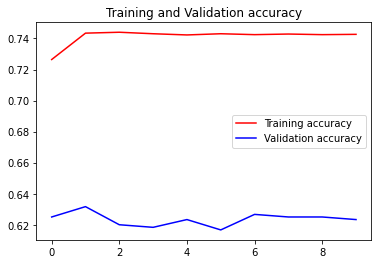

<Figure size 432x288 with 0 Axes>

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

## Save Model

In [16]:
tf.keras.models.save_model(model, filepath="./my_model/OwnCNN_EfficientNetB3_99p.h5", overwrite=True, save_format='h5')

## Train Model - v2

### Load appended data
Author provided extra data in a different directory during update.

In [ ]:
main_path = "data/chest_xray/"

test_dir, train_dir = os.path.join(main_path, "test"), os.path.join(main_path, "train")
validation_dir = os.path.join(main_path, "val") 

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0, 
    rotation_range=10, 
    width_shift_range=0.3, 
    height_shift_range=0.3, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True, 
)
test_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)
val_datagen = ImageDataGenerator(
    rescale=1.0/255.0
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150,150), 
    class_mode='binary', 
    batch_size=20
)
test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(150,150), 
    class_mode='binary', 
    batch_size=20
)
val_generator = val_datagen.flow_from_directory(
    validation_dir, 
    target_size=(150,150), 
    class_mode='binary', 
    batch_size=20
)

### Second Training

In [ ]:
history = model.fit(
    train_generator, 
    validation_data = test_generator,
    #steps_per_epoch = 100,
    epochs = 20,
    validation_steps = 50,
    verbose = 2
)

### Second Evaluation

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

### Save Model
Overwrite Previous Save

In [ ]:
tf.keras.models.save_model(model, filepath="./my_model/OwnCNN_EfficientNetB3_99p.h5", overwrite=True, save_format='h5')